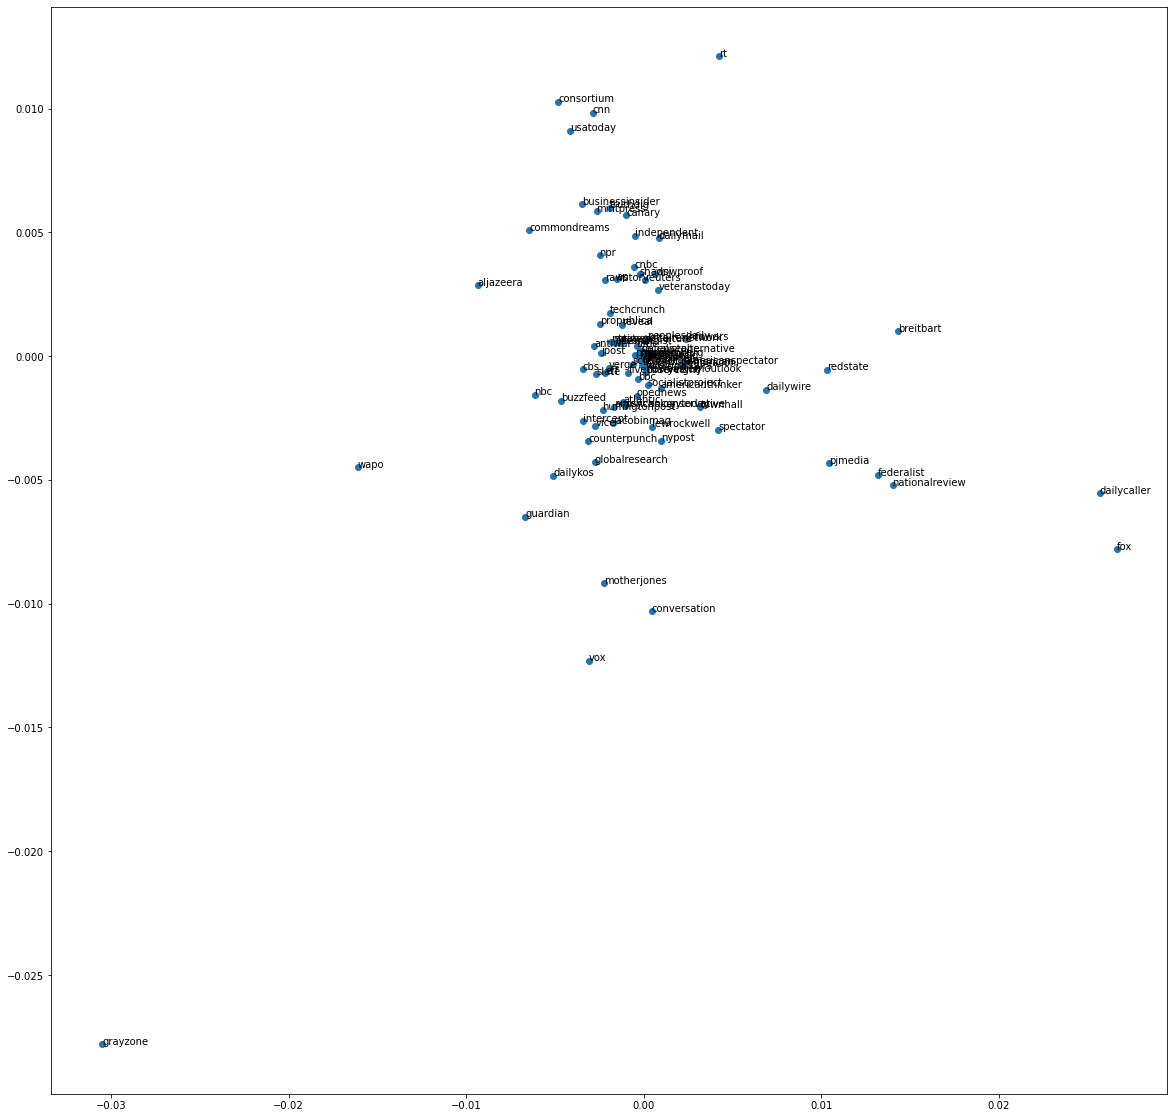

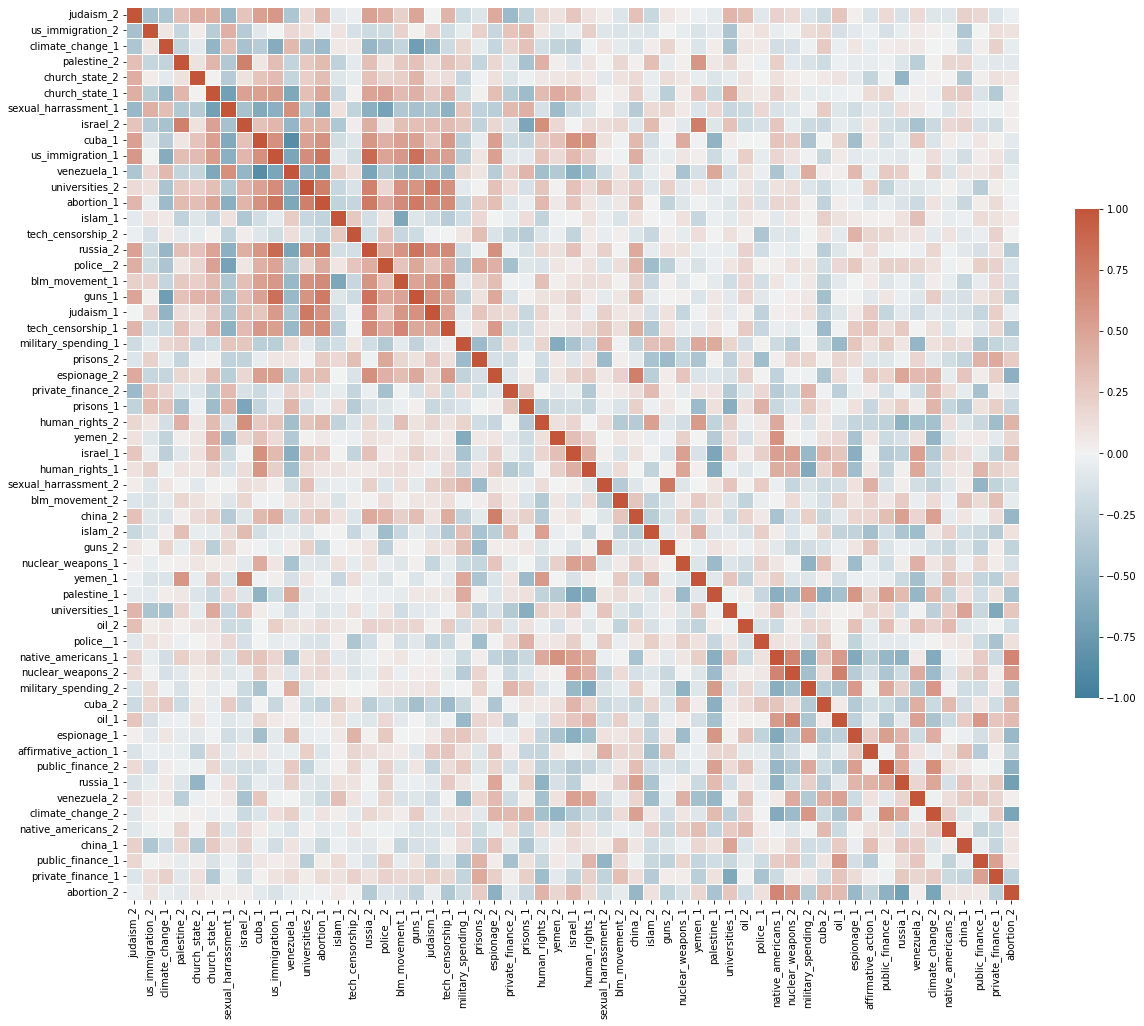

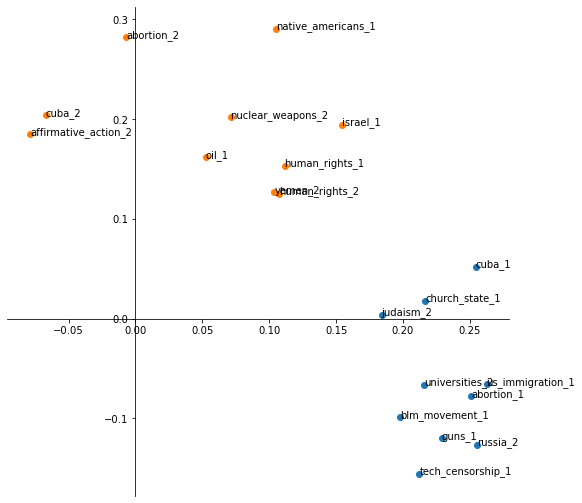

In [2]:
import os
import fnmatch
import pandas as pd
import numpy as np
from scipy.linalg import svd
from sklearn.preprocessing import normalize
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import TruncatedSVD
from scipy.stats import pearsonr
from scipy.sparse import csr_matrix

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

####ToDo: times a phrase appear in one article

####

#### Read data of each topic, process svd, get v components, v1 for left-right, v2 for establishment

#os.listdir('./phrasebias_data/phrase_counts/')
data_map = {}
media_map = {}
v_map = {}
v_map2 = {}
count = 0
for file in os.listdir('./phrasebias_data/phrase_counts/'):
    if fnmatch.fnmatch(file,'._*'):
        continue
    if count == 30:
        break
        
    df = pd.read_csv('phrasebias_data/phrase_counts/'+file)
    name = file[:-10] #better way to extract
    #df = df.drop(columns=['PHRASE','TOTAL'])
    data_map[name] = df.drop(columns=['PHRASE','TOTAL'])
    u,s,vt = svd(np.array(df.drop(columns=['PHRASE','TOTAL'])))
    v = np.transpose(vt)
    v_map[name+'1'] = v[:,1]
    v_map[name+'2'] = v[:,2]
    v_ = normalize(np.array([v[:,1],v[:,2]]))
    for i, paper in enumerate(df.columns.values[2:]):
        if paper not in media_map:
            media_map[paper] = {}
        #media_map[paper][name+'1'] = v[i,1]
        #media_map[paper][name+'2'] = v[i,2]
        media_map[paper][name+'1'] = v_[0,i]
        media_map[paper][name+'2'] = v_[1,i]
        
    count = count + 1

#### Caculate correlation map with each topic's two components, all together 28 topics with 56 components
relation = {}
for fi,vi in v_map.items():
    for fj,vj in v_map.items():
        i_j = np.intersect1d(data_map[fi[:-1]].columns.values,data_map[fj[:-1]].columns.values)
        i_list = []
        j_list = []
        for item in i_j:
            i_list.append(data_map[fi[:-1]].columns.get_loc(item))
            j_list.append(data_map[fj[:-1]].columns.get_loc(item))

        coe,p = pearsonr(vi[i_list], vj[j_list])
        if fi not in relation:
            relation[fi] = [coe]
        else:
            relation[fi].append(coe)
        #relation[fi] = {fj:coe}

#### Spectural clustering, each components i belongs to either left-right(with eigenvector v[i,1]/v[i,2]>0.5) or establishment
phrases_text = [f for f,_ in v_map.items()]

data_relation = pd.DataFrame.from_dict(relation, orient='index', columns=phrases_text) 
w, v = np.linalg.eig(data_relation)


topic_cluster = {'left_right':{}, 'establishment':{}}
for i, topic in enumerate(phrases_text):
    if abs(v[i,0]/[v[i,1]]) >= 0.5:
        topic_cluster['left_right'][topic] = abs(v[i,0])
    else:
        topic_cluster['establishment'][topic] = abs(v[i,1])

#### Calculate weighted value of each paper, e.g. axis x represent left-right, pick all left-right components and get weights average
#### To be clarified: a paper for each topic it covers has two components? altogether are the components it has?
paper_x = []
paper_y = []
paper_txt = []
for paper, data in media_map.items():
    cnt_x = 0
    sss_x = 0
    cnt_y = 0
    sss_y = 0
    for topic, val in data.items():
        if topic in topic_cluster['left_right']:
            sss_x += val*topic_cluster['left_right'][topic]
            cnt_x += 1
        if topic in topic_cluster['establishment']:
            sss_y += val*topic_cluster['establishment'][topic]
            cnt_y += 1
    if cnt_x == 0:
        paper_x.append(0)
    else:
        paper_x.append(sss_x/cnt_x)
    if cnt_y == 0:
        paper_y.append(0)
    else:
        paper_y.append(sss_y/cnt_y)
    paper_txt.append(paper)

#### Plot the paper bias
fig_paper, ax_paper = plt.subplots(figsize=(20, 20))
ax_paper.scatter(paper_x,paper_y)
for i,txt in enumerate(paper_txt):
    ax_paper.annotate(txt,(paper_x[i],paper_y[i]))

#### Plot the components correaltion map
ordered_phrases = [x for _,x in sorted(zip(np.abs(np.divide(v[:,0], v[:,1])), zip(phrases_text, range(0,len(phrases_text)-1))), 
                                       key=lambda x:x[0], reverse=True)]


ordered_relation = []

for f,corr in relation.items():
    ordered_relation.append([corr[i] for _,i in ordered_phrases])
ordered_relation = [ordered_relation[i] for _,i in ordered_phrases]

#mask = np.triu(np.ones_like(data_relation, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio

sns.heatmap(pd.DataFrame(ordered_relation, index=[p for p,_ in ordered_phrases], columns=[p for p,_ in ordered_phrases]), cmap=cmap, vmin=-1,vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Plot the clustering fig
eigen_vec = [];
for i,f in enumerate([f for f,_ in v_map.items()]):
    eigen_vec.append((v[i,0],v[i,1],f))

fig_spec, ax_spec = plt.subplots(figsize=(9, 9))

eigen_vec.sort(key=lambda x: x[0],reverse=True)
[lr_x,lr_y,lr_txt] = list(zip(*eigen_vec))
#ax.set_xlabel('entry a')
#ax.set_ylabel('entry b')
ax_spec.scatter(lr_x[:10],lr_y[:10])
#ax_spec.scatter()
for i,txt in enumerate(lr_txt[:10]):
    ax_spec.annotate(txt,(lr_x[i],lr_y[i]))

eigen_vec.sort(key=lambda x: x[1],reverse=True)
[est_x,est_y,est_txt] = list(zip(*eigen_vec))
ax_spec.scatter(est_x[:10],est_y[:10])
for i,txt in enumerate(est_txt[:10]):
    ax_spec.annotate(txt,(est_x[i],est_y[i]))
    
ax_spec.spines.left.set_position('zero')
ax_spec.spines.right.set_color('none')
ax_spec.spines.bottom.set_position('zero')
ax_spec.spines.top.set_color('none')
ax_spec.xaxis.set_ticks_position('bottom')
ax_spec.yaxis.set_ticks_position('left')
